### Copyright (C) Infineon Technologies AG 2025
 
Use of this file is subject to the terms of use agreed between (i) you or the company in which ordinary course of 
business you are acting and (ii) Infineon Technologies AG or its licensees. If and as long as no such terms of use
are agreed, use of this file is subject to following:
 
This file is licensed under the terms of the Boost Software License. See the LICENSE file in the root of this repository
for complete details.

### Notebook Structure

1. **Generation of the Model: MobileNet for Weather Classification**
2. **Compiling the Model for AURIX&trade; Microcontrollers**

# MobileNet for Weather Classification

In this an example for the classification of different weather conditions using the MobileNetV3-small [1]. The pretrained model will be the foundation applying transfer learning. The model will be tested and then transformed into code which can later be deployed on the AURIX&trade; microcontroller family. 

### Generation of the Model

In this section we will import the MobileNetV3-small. Next, we will replace the classification layer with a new one for two classes. We will train the model for weather classification and then validate the results.

In [1]:
import os
import sys

from torchsummary import summary
import modelling_helper as mh

import torch.nn as nn
import torch.optim as optim

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from CentralScripts.python_flask_client import CallTools
import CentralScripts.helper_functions as cs

Fetching data aka setting dataloader. The data which is used is Raindrop Clarify [2]. While this was designed for removing rain drops from images algorithmically, it will here be used for classification only. The data will be downloaded and restructured. From the original dataset only, clear and (rain) drop will be considered. The data will be split into train, validation (val), and test piles. Plotting a random input.

Downloaded: 100.00%Files extracted to: data
Data available in data/DayRainDrop_Train!


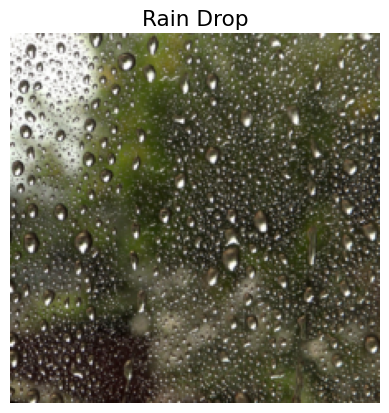

In [3]:
batch_size = 16
path = mh.fetch_sort_data()
dataloader, class_names, dataset_sizes = mh.get_dataloader(
    os.path.join(path, "train"), batch_size, mode="train"
)
_, input_size = mh.get_input_dataloader(dataloader, is_plot=True)

Loading the MobileNetV3-small with pretrained weights. It's trained on ImageNet1K dataset [3]. Replacing the classification layer with one for two classes only (rain and clear weather).

In [4]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

model_original = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
model = mh.adapt_model(model_original, number_classes=2)
summary(model, input_size, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

Applying transfer learning: training the new classification layer only.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier[-1].parameters(), lr=0.01, momentum=0.9)
mh.train_model(model, dataloader, dataset_sizes, criterion, optimizer)

Epoch 1/10
Loss: 0.1334, accuracy: 0.9476
Epoch 2/10
Loss: 0.1081, accuracy: 0.9613
Epoch 3/10
Loss: 0.1055, accuracy: 0.9615
Epoch 4/10
Loss: 0.1128, accuracy: 0.9593
Epoch 5/10
Loss: 0.1111, accuracy: 0.9572
Epoch 6/10
Loss: 0.1031, accuracy: 0.9630
Epoch 7/10
Loss: 0.1184, accuracy: 0.9581
Epoch 8/10
Loss: 0.1090, accuracy: 0.9613
Epoch 9/10
Loss: 0.1090, accuracy: 0.9623
Epoch 10/10
Loss: 0.1035, accuracy: 0.9651
Maximim accuracy: 0.9651


Getting a random input which can be used for testing on the hardware later.

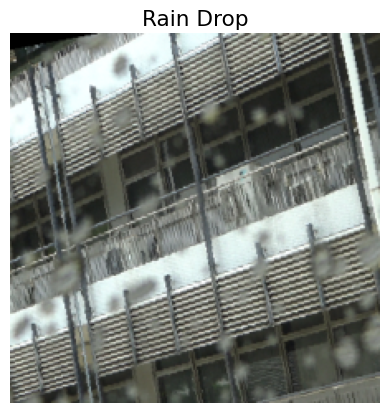

In [6]:
input_target, _ = mh.get_input_dataloader(dataloader, is_plot=True)
output_target = cs.get_predictions("torch", model, input_target)

Testing the trained model on a few samples.

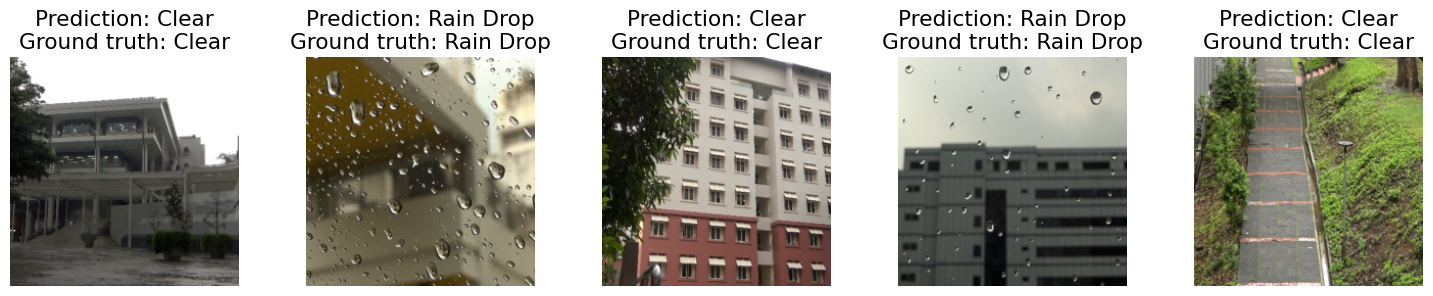

In [7]:
classes = mh.get_rain_classes()
mh.calculate_predictions_and_plot(model, os.path.join(path, "test"), classes)

Testing the trained model on the test data set.

Loss: 0.0317, accuracy: 0.9915


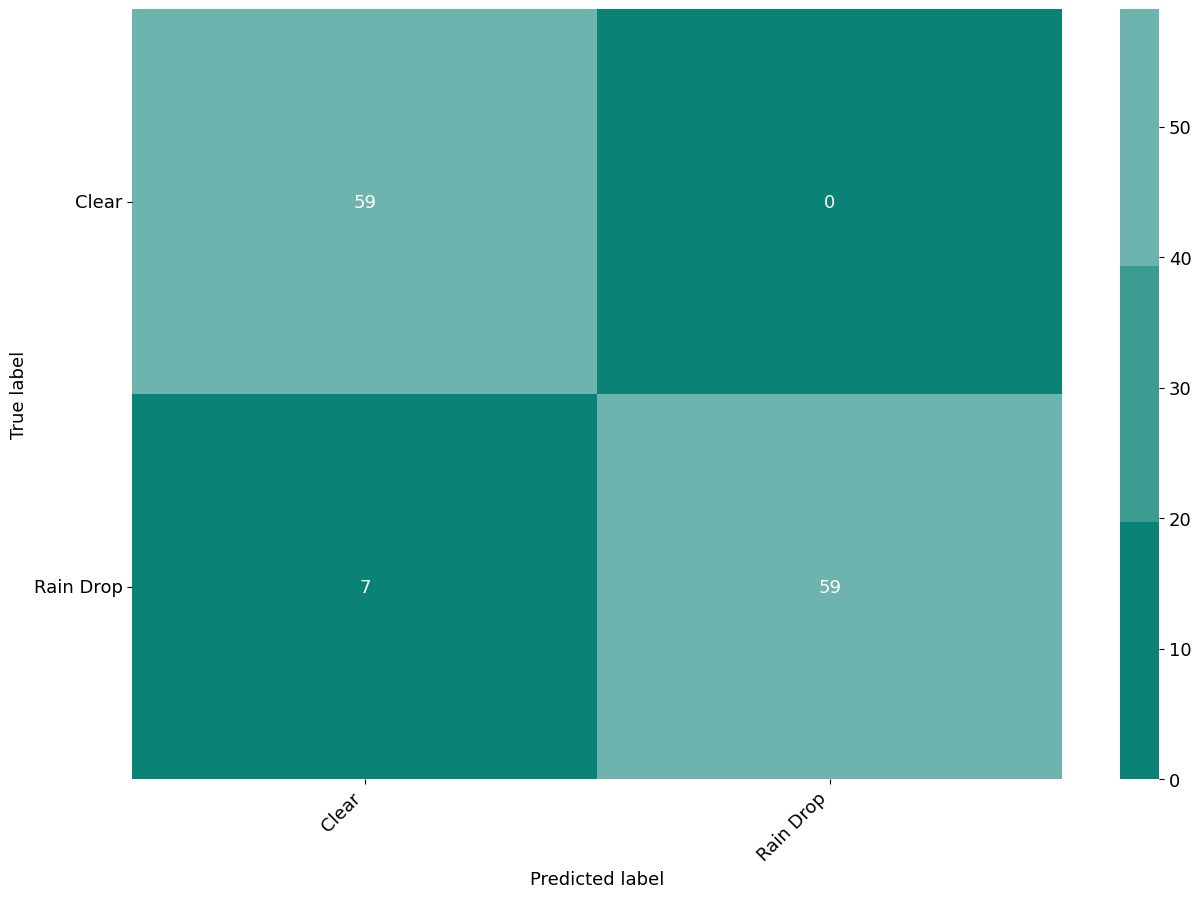

In [8]:
dataloader, class_names, dataset_sizes = mh.get_dataloader(
    os.path.join(path, "test"), batch_size, mode="test"
)
mh.test_model(model, dataloader, dataset_sizes, criterion)

Saving the model and some input and output data.

In [9]:
model_name = "mobilenet_weather"
cs.save_all(model_name, input_target, output_target, model, origin="torch")

Directory created: out/mobilenet_weather/test_mobilenet_weather
Model loaded from out/mobilenet_weather/test_mobilenet_weather/model.onnx


## Compiling the Model for AURIX&trade; Microcontrollers

For compiling, we prepare a Docker container which includes all the required tools for compilation. In this section, we will set up the container and make sure that it's available. 

In [10]:
cs.ensure_docker_container()

Docker container 'great_cohen' (from image 'docker-atv-sae-ai-public-registry.vih.infineon.com/tc_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


Compiling the model for two different targets: AURIX&trade; TC3x and TC4x.

In [11]:
model_folder, onnx_model_file = cs.get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


Comparing the run time of the layers using AURIX&trade; TC3x and TC4x.

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


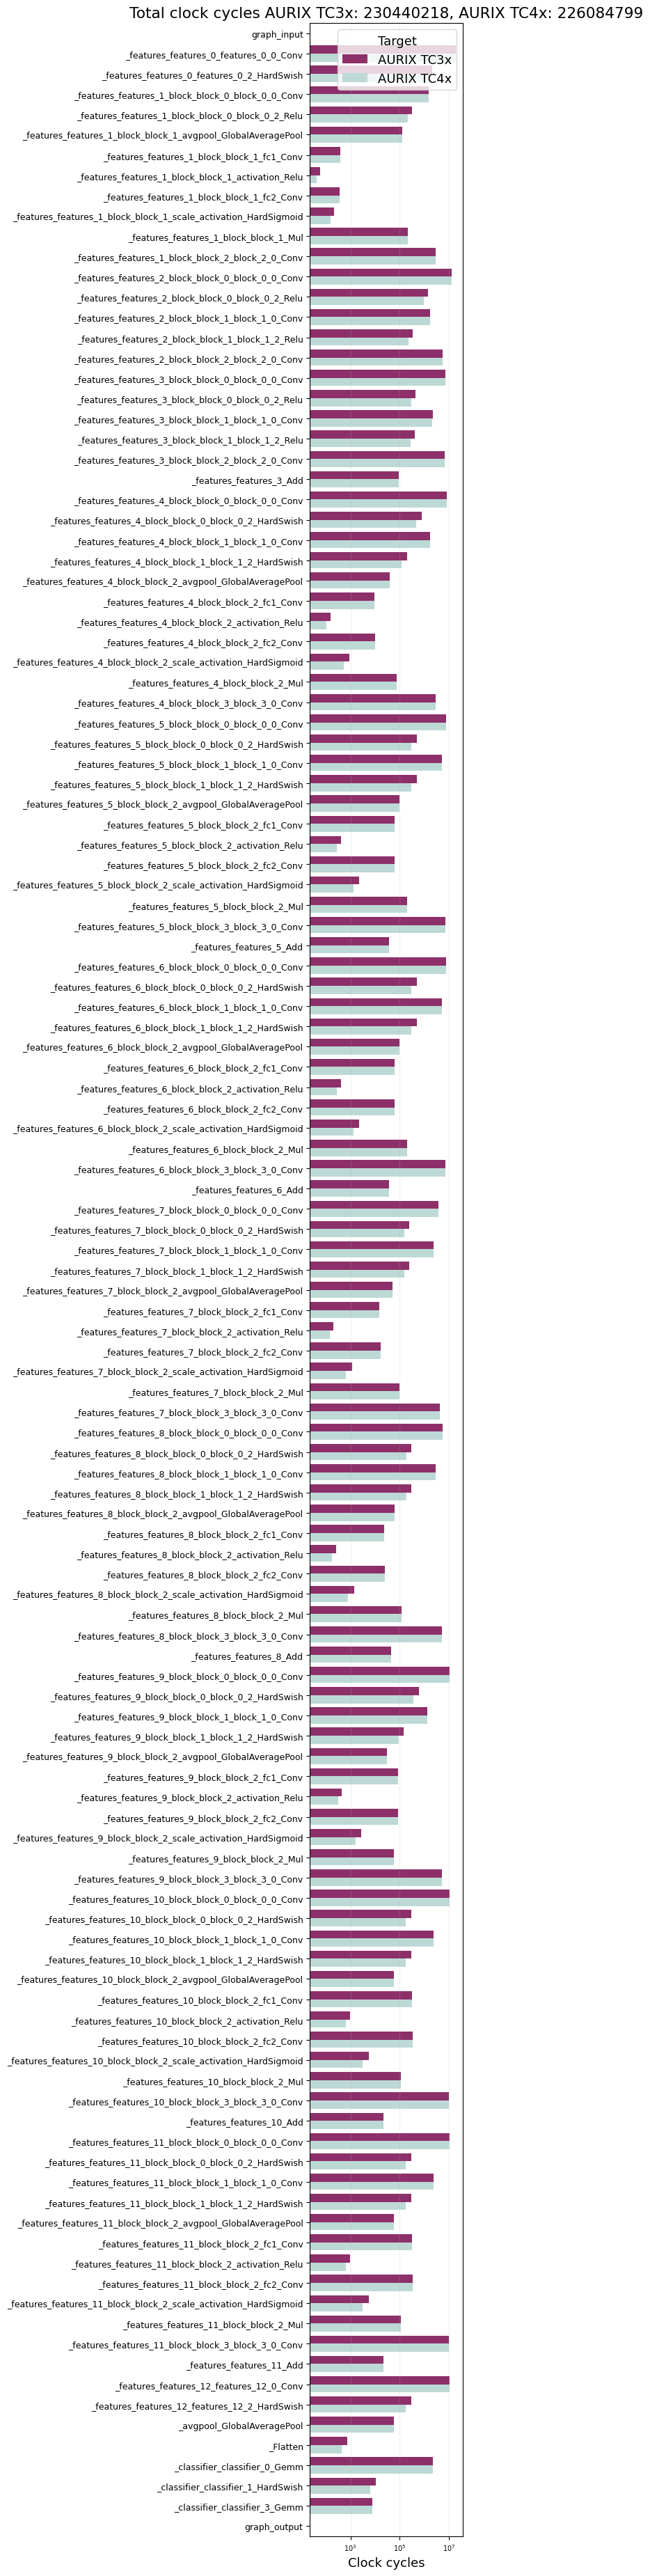

In [12]:
cs.plot_execution_timing(model_name, is_small_font=True)

[1]: Howard, A. et al. (2019). "Searching for MobileNetV3.", ICCV.<br>
[2]: Jin, Y. et al. (2024). "Raindrop Clarity: A Dual-Focused Dataset for Day and Night Raindrop Removal", ECCV, [Link to Github](https://github.com/jinyeying/RaindropClarity?tab=readme-ov-file)<br>
[3]: Russakovsky, O. et al. (2015). "ImageNet Large Scale Visual Recognition Challenge", IJCV